In [1]:
# # Setup 
# ! pip install seaborn tqdm_joblib ndlib open-iris==1.0.0

# Imports

In [ ]:
from functools import reduce
import operator

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

In [ ]:
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [3]:
n_jobs = 4 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

# Constants

In [4]:
conf_dict = {
    'no_mask':{
        'left':0.275,
        'right':0.047,
    },
    'h_len':{
        'left':{'mean':45, 'std':21, 'lower_lim':1, 'upper_lim':(Y//2)-1},
        'right':{'mean':77, 'std':17, 'lower_lim':1, 'upper_lim':(Y//2)-1},
    },
    'h_center':{
        'left':{'mean':51, 'std':15, 'lower_lim':1, 'upper_lim':(Y//2)-1},
        'right':{'mean':49, 'std':3.6, 'lower_lim':1, 'upper_lim':(Y//2)-1},
    },
    'v_len':{
        'left':{'mean':5.7, 'std':2.9, 'lower_lim':1, 'upper_lim':(X//2)-1},
        'right':{'mean':11.1, 'std':3.8, 'lower_lim':1, 'upper_lim':(X//2)-1},
    },    
}
true_mask = np.ones((X//2, Y//2), dtype=np.bool_)

# Functions

In [5]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [6]:
def generate_normal_params(num_samples, mean, std, lower_lim, upper_lim):
    return np.clip(np.random.normal(loc=mean, scale=std, size=num_samples), lower_lim, upper_lim)[0]

In [7]:
def generate_mask_part(h_center, v_len, h_len):
    blob = np.zeros((X//2, Y//2))
    blob[(X//2)-1, round(h_center)] = 1
    sigma_x, sigma_y = (v_len / 3), (h_len / 6)
    blob = gaussian_filter(blob, sigma=[sigma_x, sigma_y])
    return blob <= blob.mean()

In [8]:
def generate_single_mask():
    left_params, right_params = (
        [generate_normal_params(num_samples=1, **conf_dict[part][side]) for part in ['h_center', 'v_len', 'h_len']] for side in ['left', 'right']
    )
    left_matrix, right_matrix = (generate_mask_part(*curr_params) for curr_params in [left_params, right_params])
    final_mask = np.hstack((left_matrix, right_matrix))
    return final_mask

In [9]:
def generate_single_mask(left_prob=conf_dict['no_mask']['left'], right_prob=conf_dict['no_mask']['right']):
    def get_matrix(prob, side):
        if np.random.rand() < prob:
            return true_mask
        params = [generate_normal_params(num_samples=1, **conf_dict[part][side]) for part in ['h_center', 'v_len', 'h_len']]
        return generate_mask_part(*params)
    
    left_matrix = get_matrix(left_prob, 'left')
    right_matrix = get_matrix(right_prob, 'right')
    return np.hstack((left_matrix, right_matrix))

In [10]:
def save_masks_arrays(masks_lst, filename):
    flattened_arrays = np.stack(masks_lst).reshape(-1)
    np.packbits(flattened_arrays).tofile(filename)

In [11]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [12]:
def load_and_reshape_masks(filename, num_masks):
    flattened_data = np.unpackbits(read_partial_file(filename, ((X//2) * Y) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, X//2, Y))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [13]:
def import_voter_model_rust_implementation(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, ((X * Y) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

# Generate and save Masks

In [14]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

In [15]:
total_num_masks = 2**22
path = f'data/synthetic_iris_data/{int_to_scaled_string(total_num_masks)}_mask_arrays.dat'

In [16]:
with tqdm(total=num_masks, desc="Generating masks") as pbar:
    masks_lst = Parallel(n_jobs=n_jobs)(
        delayed(generate_single_mask)() for _ in range(num_masks)
    )
    pbar.update(1)

Generating masks:   0%|                                                                                                                                                                             | 1/4194304 [03:46<263599:57:42, 226.25s/it]


In [18]:
save_masks_arrays(masks_lst, path)

In [27]:
loaded_data = load_and_reshape_masks(path, total_num_masks)

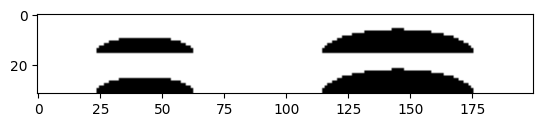

In [38]:
plot_boolean_iris(loaded_data[2][0])

# Load and save data for Rust copy-in

## Loading

In [15]:
read_num = 1000
total_num_masks = 2**22
path = f'data/synthetic_iris_data/{int_to_scaled_string(total_num_masks)}_mask_arrays.dat'
path_low = 'data/synthetic_iris_data/2_23_voter_arrays_90k_b090.dat'
path_high = 'data/synthetic_iris_data/2_23_voter_arrays_14k_b010.dat'

In [16]:
loaded_masks = load_and_reshape_masks(path, read_num).reshape(read_num, reduce(operator.mul, DIM[:2]), Y).astype(bool)

In [17]:
loaded_irises = import_voter_model_rust_implementation(path_low, path_high, read_num)

## Pairwise distances

In [30]:
pairwise_distance_distribution_lst = []
for segment in np.arange(10, 201, 10):
    left_stripe_irises = loaded_irises[:, :, :segment]
    left_stripe_masks = loaded_masks[:, :, :segment]
    pairwise_distance_distribution_lst.append(get_pairwise_min_dist_across_rotations(iris_matrices=left_stripe_irises, mask_matrices=left_stripe_masks, max_rotation=0))

In [50]:
plot_data = pd.DataFrame(np.stack(pairwise_distance_distribution_lst)).T.melt(var_name='left_stripe_len', value_name='Pairwise Distance Distribution')
plot_data['Vertical Stripe Length'] = plot_data['left_stripe_len'].replace({i:np.arange(10, 201, 10)[i] for i in range(20)})

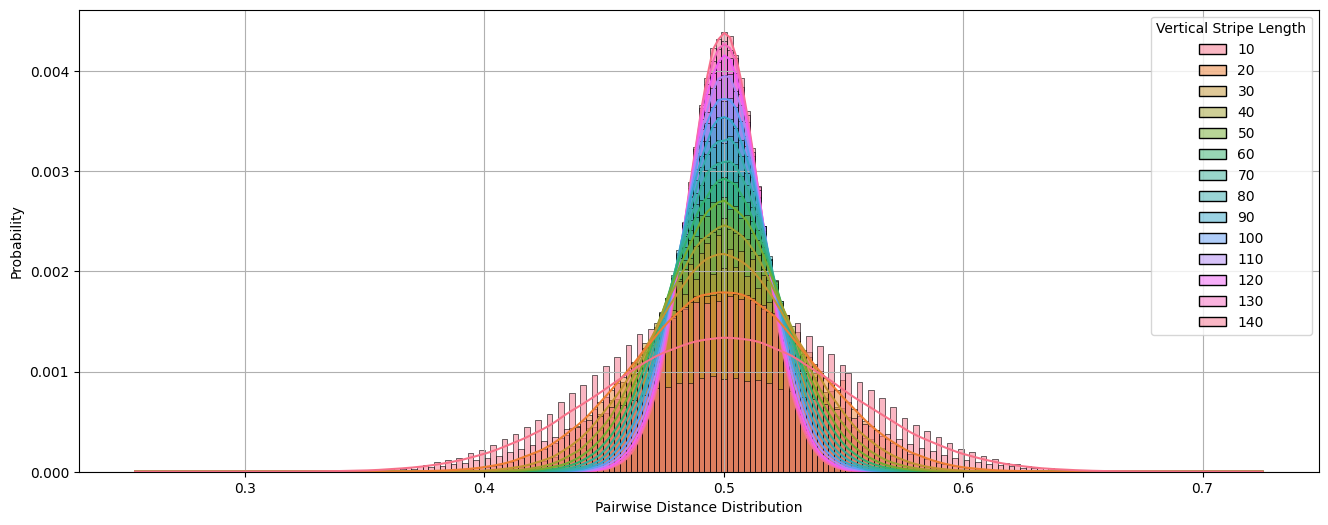

In [53]:
plt.figure(figsize=(16,6))
sns.histplot(plot_data, x='Pairwise Distance Distribution', hue='Vertical Stripe Length', palette='husl', stat='probability', kde=True, bins=200)
plt.grid()

## Applying mi & bi methodology

In [24]:
masks_reshaped = loaded_masks.reshape(read_num, reduce(operator.mul, DIM))
irises_reshaped = loaded_irises.reshape(read_num, reduce(operator.mul, DIM))

In [25]:
result = np.where(
    ~masks_reshaped, 0, np.where(irises_reshaped, -1, 1)
)

## Saving

In [26]:
filename = '100K_rust_format_synthetic_data.dat'
result.reshape(-1).tofile(filename)

## Full flow partial saving

In [ ]:
total_num_masks = 2**22
path = f'data/synthetic_iris_data/{int_to_scaled_string(total_num_masks)}_mask_arrays.dat'
path_low = 'data/synthetic_iris_data/2_23_voter_arrays_90k_b090.dat'
path_high = 'data/synthetic_iris_data/2_23_voter_arrays_14k_b010.dat'
filename_base = 'processed_masked_irises'

In [ ]:
total_chunks_sum = 1000000
chunk_size = 100000
assert total_chunks_sum % chunk_size == 0
num_chunks = total_chunks_sum // chunk_size

In [ ]:
chunk_file_names = []
for i in range(num_chunks):
    # Load chunk
    start = i * chunk_size
    loaded_masks = load_and_reshape_masks(path, chunk_size, start_sample=start).reshape(chunk_size, reduce(operator.mul, DIM)).astype(bool)
    loaded_irises = load_and_reshape_irises(path_low, path_high, chunk_size, start_sample=start).reshape(chunk_size, reduce(operator.mul, DIM))

    # Process and compress array
    packed_arr = np.where(
        ~loaded_masks, 0, np.where(loaded_irises, 2, 1)
    ).astype(np.uint8)
    compressed_data = zlib.compress(packed_arr)

    # Save array
    output_filename = f'{filename_base}_chunk_{i}.zlib'
    with open(output_filename, 'wb') as f:
        f.write(compressed_data)
    chunk_file_names.append(output_filename)

# Zip all the chunks together
zip_filename = f"{filename_base}_compressed_chunks.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for chunk_file in chunk_file_names:
        zipf.write(chunk_file, os.path.basename(chunk_file))
        os.remove(chunk_file)

print(f"Compressed and zipped all chunks into {zip_filename}")

In [ ]:
def load_compressed_chunk(chunk_index, chunk_size, DIM):
    chunk_filename = f"{filename_base}_chunk_{chunk_index}.zlib"
    with zipfile.ZipFile(f'{filename_base}_compressed_chunks.zip', 'r') as zipf:
        if chunk_filename not in zipf.namelist():
            raise FileNotFoundError(f"Chunk {chunk_index} not found in {filename_base}_compressed_chunks.zip")
        
        # Extract and decompress the specified chunk
        with zipf.open(chunk_filename) as f:
            compressed_data = f.read()
        decompressed_data = zlib.decompress(compressed_data)
        packed_arr = np.frombuffer(decompressed_data, dtype=np.uint8)
        return packed_arr.reshape(chunk_size, *DIM)